<a href="https://colab.research.google.com/github/putrimaharani355/Dataset-Narkotika_355_369/blob/main/UAS_TKI_KLASIFIKASI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#KLASIFIKASI NARKOTIKA DAN NON-NARKOTIKA


Anggota Kelompok :
1. Putri Maharani Isnainiyah	(202010370311355)
2. Erlita Setio Widianti	    (202010370311369)

#Data Collection
Data yang digunakan merupakan data **catatan amar** narkotika dan non-narkotika yang diambil dari website Mahkamah Agung

In [ ]:
!pip install pandas requests beautifulsoup4 pdfminer.six lxml > /dev/null 2>&1

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import argparse
import io
import os
import re
import time
import urllib
from concurrent.futures import ThreadPoolExecutor, wait
from datetime import date

import pandas as pd
import requests
from bs4 import BeautifulSoup
from pdfminer import high_level

def create_path(folder_name):
    path = os.path.join(os.getcwd(), folder_name)
    if not os.path.exists(path):
        os.makedirs(path)
    return path

def open_page(link):
    count = 0
    while count < 3:
        try:
            return BeautifulSoup(requests.get(link).text, "lxml")
        except:
            count += 1
            time.sleep(5)

def get_detail(soup, keyword):
    try:
        text = (
            soup.find(lambda tag: tag.name == "td" and keyword in tag.text)
            .find_next()
            .get_text()
            .strip()
        )
        return text
    except:
        return ""

def get_pdf(url, path_pdf):
    file = urllib.request.urlopen(url)
    file_name = file.info().get_filename().replace("/", " ")
    file_content = file.read()
    with open(f"{path_pdf}/{file_name}", "wb") as out_file:
        out_file.write(file_content)
    return io.BytesIO(file_content), file_name


def clean_text(text):
    text = text.replace("M a h ka m a h A g u n g R e p u blik In d o n esia\n", "")
    text = text.replace("Disclaimer\n", "")
    text = text.replace(
        "Kepaniteraan Mahkamah Agung Republik Indonesia berusaha untuk selalu mencantumkan informasi paling kini dan akurat sebagai bentuk komitmen Mahkamah Agung untuk pelayanan publik, transparansi dan akuntabilitas\n",
        "",
    )
    text = text.replace(
        "pelaksanaan fungsi peradilan. Namun dalam hal-hal tertentu masih dimungkinkan terjadi permasalahan teknis terkait dengan akurasi dan keterkinian informasi yang kami sajikan, hal mana akan terus kami perbaiki dari waktu kewaktu.\n",
        "",
    )
    text = text.replace(
        "Dalam hal Anda menemukan inakurasi informasi yang termuat pada situs ini atau informasi yang seharusnya ada, namun belum tersedia, maka harap segera hubungi Kepaniteraan Mahkamah Agung RI melalui :\n",
        "",
    )
    text = text.replace(
        "Email : kepaniteraan@mahkamahagung.go.id    Telp : 021-384 3348 (ext.318)\n",
        "",
    )
    return text

# Ini untuk extract data pdf jadi csv
def extract_data(link, keyword_url):
    global today
    global path_output
    global path_pdf
    global download_pdf

    path_output = '/content/drive/MyDrive/TKI2'
    path_pdf = '/content/drive/MyDrive/TKI2/pdf-putusan'
    today = date.today().strftime("%Y-%m-%d")

    soup = open_page(link)
    table = soup.find("table", {"class": "table"})
    judul = table.find("h2").text
    table.find("h2").decompose()

    nomor = get_detail(table, "Nomor")
    tingkat_proses = get_detail(table, "Tingkat Proses")
    klasifikasi = get_detail(table, "Klasifikasi")
    kata_kunci = get_detail(table, "Kata Kunci")
    tahun = get_detail(table, "Tahun")
    tanggal_register = get_detail(table, "Tanggal Register")
    lembaga_peradilan = get_detail(table, "Lembaga Peradilan")
    jenis_lembaga_peradilan = get_detail(table, "Jenis Lembaga Peradilan")
    hakim_ketua = get_detail(table, "Hakim Ketua")
    hakim_anggota = get_detail(table, "Hakim Anggota")
    panitera = get_detail(table, "Panitera")
    amar = get_detail(table, "Amar")
    amar_lainnya = get_detail(table, "Amar Lainnya")
    catatan_amar = get_detail(table, "Catatan Amar")
    tanggal_musyawarah = get_detail(table, "Tanggal Musyawarah")
    tanggal_dibacakan = get_detail(table, "Tanggal Dibacakan")
    kaidah = get_detail(table, "Kaidah")
    abstrak = get_detail(table, "Abstrak")

    try:
        link_pdf = soup.find("a", href=re.compile(r"/pdf/"))["href"]
        file_pdf, file_name_pdf = get_pdf(link_pdf, path_pdf)
        text_pdf = high_level.extract_text(file_pdf)
        text_pdf = clean_text(text_pdf)
    except:
        link_pdf = ""
        text_pdf = ""
        file_name_pdf = ""

    data = [
        judul,
        nomor,
        tingkat_proses,
        klasifikasi,
        kata_kunci,
        tahun,
        tanggal_register,
        lembaga_peradilan,
        jenis_lembaga_peradilan,
        hakim_ketua,
        hakim_anggota,
        panitera,
        amar,
        amar_lainnya,
        catatan_amar,
        tanggal_musyawarah,
        tanggal_dibacakan,
        kaidah,
        abstrak,
        link,
        link_pdf,
        file_name_pdf,
        text_pdf,
    ]
    result = pd.DataFrame(
        [data],
        columns=[
            "judul",
            "nomor",
            "tingkat_proses",
            "klasifikasi",
            "kata_kunci",
            "tahun",
            "tanggal_register",
            "lembaga_peradilan",
            "jenis_lembaga_peradilan",
            "hakim_ketua",
            "hakim_anggota",
            "panitera",
            "amar",
            "amar_lainnya",
            "catatan_amar",
            "tanggal_musyawarah",
            "tanggal_dibacakan",
            "kaidah",
            "abstrak",
            "link",
            "link_pdf",
            "file_name_pdf",
            "text_pdf",
        ],
    )

    keyword_url = keyword_url.replace("/", " ")
    if keyword_url.startswith("https"):
        keyword_url = ""
    #Disini kalau mau ganti output ganti ke path drive masing masing
    destination = f"{path_output}/putusan_ma_{keyword_url}_{today}"
    print(destination)
    if not os.path.isfile(f"{destination}.csv"):
        result.to_csv(f"{destination}.csv", header=True, index=False)
    else:
        result.to_csv(f"{destination}.csv", mode="a", header=False, index=False)


# Fungsi utama untuk run scraping
def run_scraper(keyword=None, url=None, sort_date=True, download_pdf=True):
    if not keyword and not url:
        print("Please provide a keyword or URL")
        return

    path_output = '/content/drive/MyDrive/TKI2/PDF'
    path_pdf = create_path("/content/drive/MyDrive/TKI2/pdf-putusan")

    today = date.today().strftime("%Y-%m-%d")

    link = f"https://putusan3.mahkamahagung.go.id/search.html?q={keyword}&page=1"

    if url:
        link = url

    soup = open_page(link)

    last_page = int(
        soup.find_all("a", {"class": "page-link"})[-1].get("data-ci-pagination-page")
    )

    if url:
        print(f"Scraping with url: {url} - {20 * last_page} data - {last_page} page")
    else:
        print(f"Scraping with keyword: {keyword} - {20 * last_page} data - {last_page} page")

    if url:
        keyword_url = url
    else:
        keyword_url = keyword

    futures = []
    with ThreadPoolExecutor(max_workers=4) as executor:
        for page in range(last_page):
            futures.append(
                executor.submit(run_process, keyword_url, page + 1, sort_date)
            )
    wait(futures)

def run_process(keyword_url, page, sort_page):

    if keyword_url.startswith("https"):
        link = f"{keyword_url}&page={page}"
    else:
        link = f"https://putusan3.mahkamahagung.go.id/search.html?q={keyword_url}&page={page}"
    if sort_page:
        link = f"{link}&obf=TANGGAL_PUTUS&obm=desc"

    print(link)

    soup = open_page(link)
    links = soup.find_all("a", {"href": re.compile("/direktori/putusan")})

    for link in links:
        extract_data(link["href"], keyword_url)

def scrape_specific_url(url, download_pdf=True):
    if not url or not url.startswith("https://"):
        print("Please provide a valid URL")
        return

    extract_data(url, url)

In [ ]:
run_scraper(url="https://putusan3.mahkamahagung.go.id/search.html?q=&jenis_doc=putusan&jd=AMAR_LAINNYA&tp=0&court=098188PN317+++++++++++++++++++++&t_put=2023&t_reg=&t_upl=&t_pr=&cat=5dc631a1c0318c606f8835603566c948")

Scraping with url: https://putusan3.mahkamahagung.go.id/search.html?q=&jenis_doc=putusan&jd=AMAR_LAINNYA&tp=0&court=098188PN317+++++++++++++++++++++&t_put=2023&t_reg=&t_upl=&t_pr=&cat=5dc631a1c0318c606f8835603566c948 - 40 data - 2 page
https://putusan3.mahkamahagung.go.id/search.html?q=&jenis_doc=putusan&jd=AMAR_LAINNYA&tp=0&court=098188PN317+++++++++++++++++++++&t_put=2023&t_reg=&t_upl=&t_pr=&cat=5dc631a1c0318c606f8835603566c948&page=1&obf=TANGGAL_PUTUS&obm=desc
https://putusan3.mahkamahagung.go.id/search.html?q=&jenis_doc=putusan&jd=AMAR_LAINNYA&tp=0&court=098188PN317+++++++++++++++++++++&t_put=2023&t_reg=&t_upl=&t_pr=&cat=5dc631a1c0318c606f8835603566c948&page=2&obf=TANGGAL_PUTUS&obm=desc
/content/drive/MyDrive/TKI2/putusan_ma__2024-01-15
/content/drive/MyDrive/TKI2/putusan_ma__2024-01-15
/content/drive/MyDrive/TKI2/putusan_ma__2024-01-15
/content/drive/MyDrive/TKI2/putusan_ma__2024-01-15
/content/drive/MyDrive/TKI2/putusan_ma__2024-01-15
/content/drive/MyDrive/TKI2/putusan_ma__2024-

In [ ]:
df=pd.read_csv('/content/drive/MyDrive/TKI2/putusan_ma__2024-01-15.csv')
df

,judul,nomor,tingkat_proses,klasifikasi,kata_kunci,tahun,tanggal_register,lembaga_peradilan,jenis_lembaga_peradilan,hakim_ketua,...,amar_lainnya,catatan_amar,tanggal_musyawarah,tanggal_dibacakan,kaidah,abstrak,link,link_pdf,file_name_pdf,text_pdf
0,Putusan PN JOMBANG Nomor 59/Pdt.G/2023/PN Jbg ...,59/Pdt.G/2023/PN Jbg,Pertama,Perdata \n Perdata Perbuatan Melawan Hukum,Perbuatan Melawan Hukum,2023,8 Agustus 2023,PN JOMBANG,PN,Hakim Ketua Muhammad Riduansyah,...,DIKABULKAN SEBAGIAN,M E N G A D I L I Mengabulkan gugatan Pengguga...,27 Desember 2023,27 Desember 2023,—,NaN,https://putusan3.mahkamahagung.go.id/direktori...,https://putusan3.mahkamahagung.go.id/direktori...,putusan_59_pdt.g_2023_pn_jbg_20240115215523.pdf,Direktori Putusan Mahkamah Agung Republik Indo...
1,Putusan PN JOMBANG Nomor 84/Pdt.G/2023/PN Jbg ...,84/Pdt.G/2023/PN Jbg,Pertama,Perdata \n Perdata Perbuatan Melawan Hukum,Perbuatan Melawan Hukum,2023,26 Oktober 2023,PN JOMBANG,PN,Hakim Ketua Sudirman,...,PENGHENTIAN PEMERIKSAAN PERKARA,MENGADILI: Menyatakan gugatan Penggugat tidak...,7 Desember 2023,7 Desember 2023,—,NaN,https://putusan3.mahkamahagung.go.id/direktori...,https://putusan3.mahkamahagung.go.id/direktori...,putusan_84_pdt.g_2023_pn_jbg_20240115215534.pdf,Direktori Putusan Mahkamah Agung Republik Indo...
2,Putusan PN JOMBANG Nomor 84/Pdt.G/2023/PN Jbg ...,84/Pdt.G/2023/PN Jbg,Pertama,Perdata \n Perdata Perbuatan Melawan Hukum,Perbuatan Melawan Hukum,2023,26 Oktober 2023,PN JOMBANG,PN,Hakim Ketua Sudirman,...,PENGHENTIAN PEMERIKSAAN PERKARA,MENGADILI: Menyatakan gugatan Penggugat tidak...,7 Desember 2023,7 Desember 2023,—,NaN,https://putusan3.mahkamahagung.go.id/direktori...,https://putusan3.mahkamahagung.go.id/direktori...,putusan_84_pdt.g_2023_pn_jbg_20240115215545.pdf,Direktori Putusan Mahkamah Agung Republik Indo...
3,Putusan PN JOMBANG Nomor 100/Pdt.G/2023/PN Jbg...,100/Pdt.G/2023/PN Jbg,Pertama,Perdata \n Perdata Perbuatan Melawan Hukum,Perbuatan Melawan Hukum,2023,22 Nopember 2023,PN JOMBANG,PN,Hakim Ketua Denndy Firdiansyah,...,DICABUT,M E N E T A P K A N : Mengabulkan Permohonan P...,6 Desember 2023,6 Desember 2023,—,NaN,https://putusan3.mahkamahagung.go.id/direktori...,https://putusan3.mahkamahagung.go.id/direktori...,putusan_100_pdt.g_2023_pn_jbg_20240115215558.pdf,Direktori Putusan Mahkamah Agung Republik Indo...
4,Putusan PN JOMBANG Nomor 80/Pdt.G/2023/PN Jbg ...,80/Pdt.G/2023/PN Jbg,Pertama,Perdata \n Perdata Perbuatan Melawan Hukum,Perbuatan Melawan Hukum,2023,18 Oktober 2023,PN JOMBANG,PN,Hakim Ketua Sudirman,...,DICABUT,M E N E T A P K A N : Mengabulkan Permohonan P...,28 Nopember 2023,28 Nopember 2023,—,NaN,https://putusan3.mahkamahagung.go.id/direktori...,NaN,NaN,NaN
5,Putusan PN JOMBANG Nomor 49/Pdt.G/2023/PN Jbg ...,49/Pdt.G/2023/PN Jbg,Pertama,Perdata \n Perdata Perbuatan Melawan Hukum,Perbuatan Melawan Hukum,2023,11 Juli 2023,PN JOMBANG,PN,Hakim Ketua Muhammad Riduansyah,...,DIKABULKAN SEBAGIAN,DALAM KONVENSIDALAM EKSEPSI Menolak eksepsi da...,9 Nopember 2023,9 Nopember 2023,—,NaN,https://putusan3.mahkamahagung.go.id/direktori...,https://putusan3.mahkamahagung.go.id/direktori...,putusan_49_pdt.g_2023_pn_jbg_20240115215616.pdf,Direktori Putusan Mahkamah Agung Republik Indo...
6,Putusan PN JOMBANG Nomor 75/Pdt.G/2023/PN Jbg ...,75/Pdt.G/2023/PN Jbg,Pertama,Perdata \n Perdata Perbuatan Melawan Hukum,Perbuatan Melawan Hukum,2023,25 September 2023,PN JOMBANG,PN,Hakim Ketua Sudirman,...,DICABUT,M E N E T A P K A N : Mengabulkan Permohonan P...,6 Nopember 2023,6 Nopember 2023,—,NaN,https://putusan3.mahkamahagung.go.id/direktori...,NaN,NaN,NaN
7,Putusan PN JOMBANG Nomor 57/Pdt.G/2023/PN Jbg ...,57/Pdt.G/2023/PN Jbg,Pertama,Perdata \n Perdata Perbuatan Melawan Hukum,Perbuatan Melawan Hukum,2023,2 Agustus 2023,PN JOMBANG,PN,Hakim Ketua Sudirman,...,PERDAMAIAN,M E N G A D I L I Menghukum kedua belah pihak...,31 Oktober 2023,31 Oktober 2023,—,NaN,https://putusan3.mahkamahagung.go.id/direktori...,NaN,NaN,NaN
8,Putusan PN JOMBANG Nomor 25/Pdt.G/2

In [ ]:
run_scraper(url="https://putusan3.mahkamahagung.go.id/search.html?q=&jenis_doc=putusan&jd=AMAR_LAINNYA&tp=0&court=098188PN317+++++++++++++++++++++&t_put=2023&t_reg=&t_upl=&t_pr=&cat=2c1ba6dc960f638b991a87475ede3d4c")

Scraping with url: https://putusan3.mahkamahagung.go.id/search.html?q=&jenis_doc=putusan&jd=AMAR_LAINNYA&tp=0&court=098188PN317+++++++++++++++++++++&t_put=2023&t_reg=&t_upl=&t_pr=&cat=2c1ba6dc960f638b991a87475ede3d4c - 40 data - 2 page
https://putusan3.mahkamahagung.go.id/search.html?q=&jenis_doc=putusan&jd=AMAR_LAINNYA&tp=0&court=098188PN317+++++++++++++++++++++&t_put=2023&t_reg=&t_upl=&t_pr=&cat=2c1ba6dc960f638b991a87475ede3d4c&page=1&obf=TANGGAL_PUTUS&obm=desc
https://putusan3.mahkamahagung.go.id/search.html?q=&jenis_doc=putusan&jd=AMAR_LAINNYA&tp=0&court=098188PN317+++++++++++++++++++++&t_put=2023&t_reg=&t_upl=&t_pr=&cat=2c1ba6dc960f638b991a87475ede3d4c&page=2&obf=TANGGAL_PUTUS&obm=desc
/content/drive/MyDrive/TKI2/putusan_ma__2024-01-15
/content/drive/MyDrive/TKI2/putusan_ma__2024-01-15
/content/drive/MyDrive/TKI2/putusan_ma__2024-01-15
/content/drive/MyDrive/TKI2/putusan_ma__2024-01-15
/content/drive/MyDrive/TKI2/putusan_ma__2024-01-15
/content/drive/MyDrive/TKI2/putusan_ma__2024-

In [ ]:
df=pd.read_csv('/content/drive/MyDrive/TKI2/putusan_ma__2024-01-15.csv')
df

,judul,nomor,tingkat_proses,klasifikasi,kata_kunci,tahun,tanggal_register,lembaga_peradilan,jenis_lembaga_peradilan,hakim_ketua,...,amar_lainnya,catatan_amar,tanggal_musyawarah,tanggal_dibacakan,kaidah,abstrak,link,link_pdf,file_name_pdf,text_pdf
0,Putusan PN JOMBANG Nomor 253/Pid.B/2023/PN Jbg...,253/Pid.B/2023/PN Jbg,Pertama,Pidana Umum \n Pidana Umum Pencurian,Pencurian,2023,20 Juli 2023,PN JOMBANG,PN,Hakim Ketua Sudirman,...,PIDANA PENJARA WAKTU TERTENTU,MENGADILI: Menyatakan Terdakwa I. Khori Nuryan...,28 Agustus 2023,28 Agustus 2023,—,NaN,https://putusan3.mahkamahagung.go.id/direktori...,https://putusan3.mahkamahagung.go.id/direktori...,putusan_253_pid.b_2023_pn_jbg_20240115222012.pdf,Direktori Putusan Mahkamah Agung Republik Indo...
1,Putusan PN JOMBANG Nomor 249/Pid.B/2023/PN Jbg...,249/Pid.B/2023/PN Jbg,Pertama,Pidana Umum \n Pidana Umum Pencurian,Pencurian,2023,20 Juli 2023,PN JOMBANG,PN,Hakim Ketua Sudirman,...,PIDANA PENJARA WAKTU TERTENTU,MENGADILI: Menyatakan Terdakwa ACHMAT MAKARIM ...,16 Agustus 2023,16 Agustus 2023,—,NaN,https://putusan3.mahkamahagung.go.id/direktori...,https://putusan3.mahkamahagung.go.id/direktori...,putusan_249_pid.b_2023_pn_jbg_20240115222024.pdf,Direktori Putusan Mahkamah Agung Republik Indo...
2,Putusan PN JOMBANG Nomor 398/Pid.B/2023/PN Jbg...,398/Pid.B/2023/PN Jbg,Pertama,Pidana Umum \n Pidana Umum Pencurian,Pencurian,2023,8 Desember 2023,PN JOMBANG,PN,Hakim Ketua Denndy Firdiansyah,...,PIDANA PENJARA WAKTU TERTENTU,MENGADILI: Menyatakan Terdakwa YASIN Bin SAKIM...,28 Desember 2023,28 Desember 2023,—,NaN,https://putusan3.mahkamahagung.go.id/direktori...,https://putusan3.mahkamahagung.go.id/direktori...,putusan_398_pid.b_2023_pn_jbg_20240115222029.pdf,Direktori Putusan Mahkamah Agung Republik Indo...
3,Putusan PN JOMBANG Nomor 250/Pid.B/2023/PN Jbg...,250/Pid.B/2023/PN Jbg,Pertama,Pidana Umum \n Pidana Umum Pencurian,Pencurian,2023,20 Juli 2023,PN JOMBANG,PN,Hakim Ketua Bagus Sumanjaya,...,PIDANA PENJARA WAKTU TERTENTU,1.MenyatakanTerdakwa M.Ardiansyah bin Harionot...,16 Agustus 2023,16 Agustus 2023,—,NaN,https://putusan3.mahkamahagung.go.id/direktori...,https://putusan3.mahkamahagung.go.id/direktori...,putusan_250_pid.b_2023_pn_jbg_20240115222046.pdf,Direktori Putusan Mahkamah Agung Republik Indo...
4,Putusan PN JOMBANG Nomor 367/Pid.B/2023/PN Jbg...,367/Pid.B/2023/PN Jbg,Pertama,Pidana Umum \n Pidana Umum Pencurian,Pencurian,2023,1 Nopember 2023,PN JOMBANG,PN,Hakim Ketua Muhammad Riduansyah,...,PIDANA PENJARA WAKTU TERTENTU,M E N G A D I L I Menyatakan Terdakwa MUTHOHAR...,7 Desember 2023,7 Desember 2023,—,NaN,https://putusan3.mahkamahagung.go.id/direktori...,https://putusan3.mahkamahagung.go.id/direktori...,putusan_367_pid.b_2023_pn_jbg_20240115222052.pdf,Direktori Putusan Mahkamah Agung Republik Indo...
5,Putusan PN JOMBANG Nomor 240/Pid.B/2023/PN Jbg...,240/Pid.B/2023/PN Jbg,Pertama,Pidana Umum \n Pidana Umum Pencurian,Pencurian,2023,13 Juli 2023,PN JOMBANG,PN,Hakim Ketua Ida Ayu Masyuni,...,PIDANA PENJARA WAKTU TERTENTU,M E N G A D I L I; Menyatakan Terdakwa Khabibu...,15 Agustus 2023,15 Agustus 2023,—,NaN,https://putusan3.mahkamahagung.go.id/direktori...,https://putusan3.mahkamahagung.go.id/direktori...,putusan_240_pid.b_2023_pn_jbg_20240115222110.pdf,Direktori Putusan Mahkamah Agung Republik Indo...
6,Putusan PN JOMBANG Nomor 350/Pid.B/2023/PN Jbg...,350/Pid.B/2023/PN Jbg,Pertama,Pidana Umum \n Pidana Umum Pencurian,Pencurian,2023,13 Oktober 2023,PN JOMBANG,PN,Hakim Ketua Muhammad Riduansyah,...,PIDANA PENJARA WAKTU TERTENTU,Menyatakan Terdakwa MOH ARIFUDIN Bin SUTAJI te...,7 Desember 2023,7 Desember 2023,—,NaN,https://putusan3.mahkamahagung.go.id/direktori...,https://putusan3.mahkamahagung.go.id/direktori...,putusan_350_pid.b_2023_pn_jbg_20240115222116.pdf,Direktori Putusan Mahkamah Agung Republik Indo...
7,Putusan PN JOMBANG Nomor 220/Pid.B/2023/PN Jbg...,220/Pid.B/2023/PN Jbg,Pertama,Pidana Umum \n Pidana Umum Pencurian,Pencurian,2023,20 Juni 2023,PN JOMBANG,PN,Hakim Ketua Ba

* Menggabungkan file-file untuk menjadi data non narkotika




In [ ]:
import pandas as pd

# Baca dua file CSV
file1 = pd.read_csv('/content/drive/MyDrive/TKI2/putusan_ma__2024-01-15.csv')
file2 = pd.read_csv('/content/drive/MyDrive/TKI2(perbuatan melawan hukum)/putusan_ma__2024-01-15.csv')

# Gabungkan berdasarkan baris
DataNonNarkotika = pd.concat([file1, file2], ignore_index=True)

# Simpan hasil ke dalam satu file CSV
DataNonNarkotika.to_csv('combined_file.csv', index=False)

In [ ]:
DataNonNarkotika

,judul,nomor,tingkat_proses,klasifikasi,kata_kunci,tahun,tanggal_register,lembaga_peradilan,jenis_lembaga_peradilan,hakim_ketua,...,amar_lainnya,catatan_amar,tanggal_musyawarah,tanggal_dibacakan,kaidah,abstrak,link,link_pdf,file_name_pdf,text_pdf
0,Putusan PN JOMBANG Nomor 253/Pid.B/2023/PN Jbg...,253/Pid.B/2023/PN Jbg,Pertama,Pidana Umum \n Pidana Umum Pencurian,Pencurian,2023,20 Juli 2023,PN JOMBANG,PN,Hakim Ketua Sudirman,...,PIDANA PENJARA WAKTU TERTENTU,MENGADILI: Menyatakan Terdakwa I. Khori Nuryan...,28 Agustus 2023,28 Agustus 2023,—,NaN,https://putusan3.mahkamahagung.go.id/direktori...,https://putusan3.mahkamahagung.go.id/direktori...,putusan_253_pid.b_2023_pn_jbg_20240115222012.pdf,Direktori Putusan Mahkamah Agung Republik Indo...
1,Putusan PN JOMBANG Nomor 249/Pid.B/2023/PN Jbg...,249/Pid.B/2023/PN Jbg,Pertama,Pidana Umum \n Pidana Umum Pencurian,Pencurian,2023,20 Juli 2023,PN JOMBANG,PN,Hakim Ketua Sudirman,...,PIDANA PENJARA WAKTU TERTENTU,MENGADILI: Menyatakan Terdakwa ACHMAT MAKARIM ...,16 Agustus 2023,16 Agustus 2023,—,NaN,https://putusan3.mahkamahagung.go.id/direktori...,https://putusan3.mahkamahagung.go.id/direktori...,putusan_249_pid.b_2023_pn_jbg_20240115222024.pdf,Direktori Putusan Mahkamah Agung Republik Indo...
2,Putusan PN JOMBANG Nomor 398/Pid.B/2023/PN Jbg...,398/Pid.B/2023/PN Jbg,Pertama,Pidana Umum \n Pidana Umum Pencurian,Pencurian,2023,8 Desember 2023,PN JOMBANG,PN,Hakim Ketua Denndy Firdiansyah,...,PIDANA PENJARA WAKTU TERTENTU,MENGADILI: Menyatakan Terdakwa YASIN Bin SAKIM...,28 Desember 2023,28 Desember 2023,—,NaN,https://putusan3.mahkamahagung.go.id/direktori...,https://putusan3.mahkamahagung.go.id/direktori...,putusan_398_pid.b_2023_pn_jbg_20240115222029.pdf,Direktori Putusan Mahkamah Agung Republik Indo...
3,Putusan PN JOMBANG Nomor 250/Pid.B/2023/PN Jbg...,250/Pid.B/2023/PN Jbg,Pertama,Pidana Umum \n Pidana Umum Pencurian,Pencurian,2023,20 Juli 2023,PN JOMBANG,PN,Hakim Ketua Bagus Sumanjaya,...,PIDANA PENJARA WAKTU TERTENTU,1.MenyatakanTerdakwa M.Ardiansyah bin Harionot...,16 Agustus 2023,16 Agustus 2023,—,NaN,https://putusan3.mahkamahagung.go.id/direktori...,https://putusan3.mahkamahagung.go.id/direktori...,putusan_250_pid.b_2023_pn_jbg_20240115222046.pdf,Direktori Putusan Mahkamah Agung Republik Indo...
4,Putusan PN JOMBANG Nomor 367/Pid.B/2023/PN Jbg...,367/Pid.B/2023/PN Jbg,Pertama,Pidana Umum \n Pidana Umum Pencurian,Pencurian,2023,1 Nopember 2023,PN JOMBANG,PN,Hakim Ketua Muhammad Riduansyah,...,PIDANA PENJARA WAKTU TERTENTU,M E N G A D I L I Menyatakan Terdakwa MUTHOHAR...,7 Desember 2023,7 Desember 2023,—,NaN,https://putusan3.mahkamahagung.go.id/direktori...,https://putusan3.mahkamahagung.go.id/direktori...,putusan_367_pid.b_2023_pn_jbg_20240115222052.pdf,Direktori Putusan Mahkamah Agung Republik Indo...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,Putusan PN JOMBANG Nomor 12/Pdt.G/2023/PN Jbg ...,12/Pdt.G/2023/PN Jbg,Pertama,Perdata \n Perdata Perbuatan Melawan Hukum,Perbuatan Melawan Hukum,2023,27 Februari 2023,PN JOMBANG,PN,Hakim Ketua Denndy Firdiansyah,...,MENGABULKAN EKSEPSI,MENGADILI: Mengabulkan eksepsi Tergugat I; Men...,31 Agustus 2023,31 Agustus 2023,—,NaN,https://putusan3.mahkamahagung.go.id/direktori...,https://putusan3.mahkamahagung.go.id/direktori...,putusan_12_pdt.g_2023_pn_jbg_20240115220002.pdf,Direktori Putusan Mahkamah Agung Republik Indo...
65,Putusan PN JOMBANG Nomor 47/Pdt.G/2023/PN Jbg ...,47/Pdt.G/2023/PN Jbg,Pertama,Perdata \n Perdata Perbuatan Melawan Hukum,Perbuatan Melawan Hukum,2023,11 Juli 2023,PN JOMBANG,PN,Hakim Ketua Denndy Firdiansyah,...,DICABUT,M E N E T A P K A N : Mengabulkan permohonan p...,23 Agustus 2023,23 Agustus 2023,—,NaN,https://putusan3.mahkamahagung.go.id/direktori...,https://putusan3.mahkamahagung.go.id/direktori...,putusan_47_pdt.g_2023_pn_jbg_20240115220014.pdf,Direktori Putusan Mahkamah Agung Republik Indo...
66,Putusan PN SURABAYA Nomor 2257/Pid.Sus/2023/PN...,2257/Pid.Sus/2023/PN Sby,

#PREPROCESSING DATA NARKOTIKA
1. Pemberian Label
2. Melakukan lowercase
3. Remove single char
4. Remove punctuation, digits, and whitespace
5. Remove Stopwords
6. Tokenize
7. Lemmesisasi

## Pemberian Label

In [ ]:
DataNarkotika = pd.read_csv('/content/Overview.csv')
DataNarkotika

,nomor,lembaga_peradilan,catatan_amar,barang_bukti
0,336/Pid.Sus/2023/PN Jbg,PN JOMBANG,Menyatakan Terdakwa BAGUS NURDIANSYAH Bin SUDA...,: 1(satu) buah tas slempang warna biru cream m...
1,130/Pid.Sus/2023/PN Jbg,PN JOMBANG,Menyatakan Terdakwa MUHAMMAD ABDI YUNUS alias ...,: 1 pipet kaca yang berisi sisa pemakaian sabu...
2,324/Pid.Sus/2023/PN Jbg,PN JOMBANG,M E N G A D I L I : Menyatakan Terdakwa Banyu ...,: 1 (satu) plastik klip yang didalamnya berisi...
3,282/Pid.Sus/2023/PN Jbg,PN JOMBANG,Menyatakan Terdakwa DWI PURWANTO Bin KASTURI t...,: 1 (satu) Paket plastik klip kosong; 1 (satu)...
4,147/Pid.Sus/2023/PN Jbg,PN JOMBANG,Menyatakan Terdakwa AGUS SAMPURNO bin SUWONO (...,: 1 (satu) plastik klip berisi sabu berat koto...
...,...,...,...,...
164,605/Pid.Sus/2022/PN Jbg,PN JOMBANG,Menyatakan Terdakwa SUWANTO Alis SAWER telah t...,": Pipet kaca berisi sabu dengan berat kotor 1,..."
165,604/Pid.Sus/2022/PN Jbg,PN JOMBANG,MENGADILI Menyatakan Terdakwa AGUS SUPRIYANTO...,": 1 (satu) plastik klip sabu berat kotor 0,34 ..."
166,2191/Pdt.G/2023/PA.Kdl,PA KENDAL,Menyatakan Tergugat yang telah dipanggil secar...,NaN
167,71/Pid.Sus/2023/PN Lss,PN Lasusua,MENGADILI: Menyatakan Terdakwa Abd. Majid Alia...,: 1 (satu) lembar baju kaos lengan pendek berk...


In [ ]:
columns_to_drop = ['nomor', 'lembaga_peradilan', 'barang_bukti']  # List of column names to be dropped
DataNarkotika = DataNarkotika.drop(columns_to_drop, axis=1)

In [ ]:
DataNarkotika

,catatan_amar
0,Menyatakan Terdakwa BAGUS NURDIANSYAH Bin SUDA...
1,Menyatakan Terdakwa MUHAMMAD ABDI YUNUS alias ...
2,M E N G A D I L I : Menyatakan Terdakwa Banyu ...
3,Menyatakan Terdakwa DWI PURWANTO Bin KASTURI t...
4,Menyatakan Terdakwa AGUS SAMPURNO bin SUWONO (...
...,...
164,Menyatakan Terdakwa SUWANTO Alis SAWER telah t...
165,MENGADILI Menyatakan Terdakwa AGUS SUPRIYANTO...
166,Menyatakan Tergugat yang telah dipanggil secar...
167,MENGADILI: Menyatakan Terdakwa Abd. Majid Alia...


In [ ]:
DataNarkotika["Label"] = 1
DataNarkotika.head()

,catatan_amar,Label
0,Menyatakan Terdakwa BAGUS NURDIANSYAH Bin SUDA...,1
1,Menyatakan Terdakwa MUHAMMAD ABDI YUNUS alias ...,1
2,M E N G A D I L I : Menyatakan Terdakwa Banyu ...,1
3,Menyatakan Terdakwa DWI PURWANTO Bin KASTURI t...,1
4,Menyatakan Terdakwa AGUS SAMPURNO bin SUWONO (...,1


## Lowercase

In [ ]:
DataNarkotika['catatan_amar'] = DataNarkotika['catatan_amar'].str.lower() #ubah hruf besar ke kecil
DataNarkotika

,catatan_amar,Label
0,menyatakan terdakwa bagus nurdiansyah bin suda...,1
1,menyatakan terdakwa muhammad abdi yunus alias ...,1
2,m e n g a d i l i : menyatakan terdakwa banyu ...,1
3,menyatakan terdakwa dwi purwanto bin kasturi t...,1
4,menyatakan terdakwa agus sampurno bin suwono (...,1
...,...,...
164,menyatakan terdakwa suwanto alis sawer telah t...,1
165,mengadili menyatakan terdakwa agus supriyanto...,1
166,menyatakan tergugat yang telah dipanggil secar...,1
167,mengadili: menyatakan terdakwa abd. majid alia...,1


## Remove single Char

In [ ]:
def remove_single_char (text):
  text = re.sub(r"\b[a-zA-Z]\b", "",text)
  return text

DataNarkotika['catatan_amar'] = DataNarkotika['catatan_amar'].apply(remove_single_char)
print(DataNarkotika['catatan_amar'])

0      menyatakan terdakwa bagus nurdiansyah bin suda...
1      menyatakan terdakwa muhammad abdi yunus alias ...
2               : menyatakan terdakwa banyu topan bin...
3      menyatakan terdakwa dwi purwanto bin kasturi t...
4      menyatakan terdakwa agus sampurno bin suwono (...
                             ...                        
164    menyatakan terdakwa suwanto alis sawer telah t...
165    mengadili  menyatakan terdakwa agus supriyanto...
166    menyatakan tergugat yang telah dipanggil secar...
167    mengadili: menyatakan terdakwa abd. majid alia...
168    mengadili menyatakan tergugat yang telah dipan...
Name: catatan_amar, Length: 169, dtype: object


## Remove punctuation, digits, and whitespace

In [ ]:
def remove_punctuation_digits_whitespace(text):
    # Hapus tanda baca
    text = re.sub(r'[^\w\s]', '', text)

    # Hapus angka
    text = re.sub(r'\d', '', text)

    # Hapus spasi putih
    text = re.sub(r'\s+', ' ', text).strip()

    return text

DataNarkotika['catatan_amar'] = DataNarkotika['catatan_amar'].apply(remove_punctuation_digits_whitespace)
print(DataNarkotika['catatan_amar'])

0      menyatakan terdakwa bagus nurdiansyah bin suda...
1      menyatakan terdakwa muhammad abdi yunus alias ...
2      menyatakan terdakwa banyu topan bin kasiman te...
3      menyatakan terdakwa dwi purwanto bin kasturi t...
4      menyatakan terdakwa agus sampurno bin suwono a...
                             ...                        
164    menyatakan terdakwa suwanto alis sawer telah t...
165    mengadili menyatakan terdakwa agus supriyanto ...
166    menyatakan tergugat yang telah dipanggil secar...
167    mengadili menyatakan terdakwa abd majid alias ...
168    mengadili menyatakan tergugat yang telah dipan...
Name: catatan_amar, Length: 169, dtype: object


## Remove Stopword

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Fungsi untuk stopword removal pada bahasa Indonesia
def remove_stopwords(text):
    stop_words = set(stopwords.words('indonesian'))
    tokens = word_tokenize(text)
    filtered_tokens = [word for word in tokens if word.lower() not in stop_words]
    return ' '.join(filtered_tokens)

# Contoh penggunaan pada kolom 'catatan_amar'
DataNarkotika['catatan_amar'] = DataNarkotika['catatan_amar'].apply(remove_stopwords)

# Menampilkan hasil stopword removal
print(DataNarkotika['catatan_amar'])


0      terdakwa bagus nurdiansyah bin sudarto terbukt...
1      terdakwa muhammad abdi yunus alias ganden bin ...
2      terdakwa banyu topan bin kasiman diatas terbuk...
3      terdakwa dwi purwanto bin kasturi terbukti sah...
4      terdakwa agus sampurno bin suwono alm terbukti...
                             ...                        
164    terdakwa suwanto alis sawer terbukti sah bersa...
165    mengadili terdakwa agus supriyanto bin kasban ...
166    tergugat dipanggil resmi patut menghadap persi...
167    mengadili terdakwa abd majid alias majid bin h...
168    mengadili tergugat dipanggil resmi patut hadir...
Name: catatan_amar, Length: 169, dtype: object


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Tokenize

In [ ]:
def tokenize_text(text):
    # Tokenisasi menggunakan word_tokenize dari nltk
    tokens = word_tokenize(text)

    return tokens
DataNarkotika['catatan_amar'] = DataNarkotika['catatan_amar'].apply(tokenize_text)
print(DataNarkotika['catatan_amar'])

0      [terdakwa, bagus, nurdiansyah, bin, sudarto, t...
1      [terdakwa, muhammad, abdi, yunus, alias, gande...
2      [terdakwa, banyu, topan, bin, kasiman, diatas,...
3      [terdakwa, dwi, purwanto, bin, kasturi, terbuk...
4      [terdakwa, agus, sampurno, bin, suwono, alm, t...
                             ...                        
164    [terdakwa, suwanto, alis, sawer, terbukti, sah...
165    [mengadili, terdakwa, agus, supriyanto, bin, k...
166    [tergugat, dipanggil, resmi, patut, menghadap,...
167    [mengadili, terdakwa, abd, majid, alias, majid...
168    [mengadili, tergugat, dipanggil, resmi, patut,...
Name: catatan_amar, Length: 169, dtype: object


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Lemmenize

In [ ]:
pip install Sastrawi


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 3.5 MB/s eta 0:00:00


In [ ]:
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

# Fungsi untuk lemmatisasi setiap kata dalam daftar kata
def lemmatize_list_of_words(word_list):
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()

    # Lemmatisasi setiap kata dalam daftar
    lemmatized_words = [stemmer.stem(word) for word in word_list]
    return lemmatized_words

# Melakukan lemmatisasi pada kolom 'catatan_amar'
DataNarkotika['catatan_amar'] = DataNarkotika['catatan_amar'].apply(lemmatize_list_of_words)

# Menampilkan hasil lemmatisasi
print(DataNarkotika['catatan_amar'])


0      [dakwa, bagus, nurdiansyah, bin, sudarto, bukt...
1      [dakwa, muhammad, abdi, yunus, alias, ganden, ...
2      [dakwa, banyu, topan, bin, kasim, atas, bukti,...
3      [dakwa, dwi, purwanto, bin, kasturi, bukti, sa...
4      [dakwa, agus, sampurno, bin, suwono, alm, bukt...
                             ...                        
164    [dakwa, suwanto, alis, sawer, bukti, sah, sala...
165    [adil, dakwa, agus, supriyanto, bin, kasban, a...
166    [gugat, panggil, resmi, patut, hadap, sidang, ...
167    [adil, dakwa, abd, majid, alias, majid, bin, h...
168    [adil, gugat, panggil, resmi, patut, hadir, si...
Name: catatan_amar, Length: 169, dtype: object


## Combined cleaned Text

In [ ]:
# combine cleaned text after removing stop words into one string
DataNarkotika['Putusan-Final'] = DataNarkotika['catatan_amar'].apply(lambda x: ' '.join(x))
DataNarkotika.head()

,catatan_amar,Label,Putusan-Final
0,"[dakwa, bagus, nurdiansyah, bin, sudarto, bukt...",1,dakwa bagus nurdiansyah bin sudarto bukti sah ...
1,"[dakwa, muhammad, abdi, yunus, alias, ganden, ...",1,dakwa muhammad abdi yunus alias ganden bin alm...
2,"[dakwa, banyu, topan, bin, kasim, atas, bukti,...",1,dakwa banyu topan bin kasim atas bukti sah sal...
3,"[dakwa, dwi, purwanto, bin, kasturi, bukti, sa...",1,dakwa dwi purwanto bin kasturi bukti sah salah...
4,"[dakwa, agus, sampurno, bin, suwono, alm, bukt...",1,dakwa agus sampurno bin suwono alm bukti sah s...


In [ ]:
columns_to_drop = ['catatan_amar']  # List of column names to be dropped
DataNarkotika = DataNarkotika.drop(columns_to_drop, axis=1)
DataNarkotika

,Label,Putusan-Final
0,1,dakwa bagus nurdiansyah bin sudarto bukti sah ...
1,1,dakwa muhammad abdi yunus alias ganden bin alm...
2,1,dakwa banyu topan bin kasim atas bukti sah sal...
3,1,dakwa dwi purwanto bin kasturi bukti sah salah...
4,1,dakwa agus sampurno bin suwono alm bukti sah s...
...,...,...
164,1,dakwa suwanto alis sawer bukti sah salah tinda...
165,1,adil dakwa agus supriyanto bin kasban atas buk...
166,1,gugat panggil resmi patut hadap sidang hadir k...
167,1,adil dakwa abd majid alias majid bin hasrul at...


# PREPROCESSING NON-NARKOTIKA  
1. Pemberian Label
2. Melakukan lowercase
3. Remove single char
4. Remove punctuation, digits, and whitespace
5. Remove Stopwords
6. Tokenize
7. Lemmesisasi

## Pemberian Label

In [ ]:
DataNonNarkotika = pd.read_csv('/content/combined_file.csv')
DataNonNarkotika

,judul,nomor,tingkat_proses,klasifikasi,kata_kunci,tahun,tanggal_register,lembaga_peradilan,jenis_lembaga_peradilan,hakim_ketua,...,amar_lainnya,catatan_amar,tanggal_musyawarah,tanggal_dibacakan,kaidah,abstrak,link,link_pdf,file_name_pdf,text_pdf
0,Putusan PN JOMBANG Nomor 253/Pid.B/2023/PN Jbg...,253/Pid.B/2023/PN Jbg,Pertama,Pidana Umum \n Pidana Umum Pencurian,Pencurian,2023,20 Juli 2023,PN JOMBANG,PN,Hakim Ketua Sudirman,...,PIDANA PENJARA WAKTU TERTENTU,MENGADILI: Menyatakan Terdakwa I. Khori Nuryan...,28 Agustus 2023,28 Agustus 2023,—,NaN,https://putusan3.mahkamahagung.go.id/direktori...,https://putusan3.mahkamahagung.go.id/direktori...,putusan_253_pid.b_2023_pn_jbg_20240115222012.pdf,Direktori Putusan Mahkamah Agung Republik Indo...
1,Putusan PN JOMBANG Nomor 249/Pid.B/2023/PN Jbg...,249/Pid.B/2023/PN Jbg,Pertama,Pidana Umum \n Pidana Umum Pencurian,Pencurian,2023,20 Juli 2023,PN JOMBANG,PN,Hakim Ketua Sudirman,...,PIDANA PENJARA WAKTU TERTENTU,MENGADILI: Menyatakan Terdakwa ACHMAT MAKARIM ...,16 Agustus 2023,16 Agustus 2023,—,NaN,https://putusan3.mahkamahagung.go.id/direktori...,https://putusan3.mahkamahagung.go.id/direktori...,putusan_249_pid.b_2023_pn_jbg_20240115222024.pdf,Direktori Putusan Mahkamah Agung Republik Indo...
2,Putusan PN JOMBANG Nomor 398/Pid.B/2023/PN Jbg...,398/Pid.B/2023/PN Jbg,Pertama,Pidana Umum \n Pidana Umum Pencurian,Pencurian,2023,8 Desember 2023,PN JOMBANG,PN,Hakim Ketua Denndy Firdiansyah,...,PIDANA PENJARA WAKTU TERTENTU,MENGADILI: Menyatakan Terdakwa YASIN Bin SAKIM...,28 Desember 2023,28 Desember 2023,—,NaN,https://putusan3.mahkamahagung.go.id/direktori...,https://putusan3.mahkamahagung.go.id/direktori...,putusan_398_pid.b_2023_pn_jbg_20240115222029.pdf,Direktori Putusan Mahkamah Agung Republik Indo...
3,Putusan PN JOMBANG Nomor 250/Pid.B/2023/PN Jbg...,250/Pid.B/2023/PN Jbg,Pertama,Pidana Umum \n Pidana Umum Pencurian,Pencurian,2023,20 Juli 2023,PN JOMBANG,PN,Hakim Ketua Bagus Sumanjaya,...,PIDANA PENJARA WAKTU TERTENTU,1.MenyatakanTerdakwa M.Ardiansyah bin Harionot...,16 Agustus 2023,16 Agustus 2023,—,NaN,https://putusan3.mahkamahagung.go.id/direktori...,https://putusan3.mahkamahagung.go.id/direktori...,putusan_250_pid.b_2023_pn_jbg_20240115222046.pdf,Direktori Putusan Mahkamah Agung Republik Indo...
4,Putusan PN JOMBANG Nomor 367/Pid.B/2023/PN Jbg...,367/Pid.B/2023/PN Jbg,Pertama,Pidana Umum \n Pidana Umum Pencurian,Pencurian,2023,1 Nopember 2023,PN JOMBANG,PN,Hakim Ketua Muhammad Riduansyah,...,PIDANA PENJARA WAKTU TERTENTU,M E N G A D I L I Menyatakan Terdakwa MUTHOHAR...,7 Desember 2023,7 Desember 2023,—,NaN,https://putusan3.mahkamahagung.go.id/direktori...,https://putusan3.mahkamahagung.go.id/direktori...,putusan_367_pid.b_2023_pn_jbg_20240115222052.pdf,Direktori Putusan Mahkamah Agung Republik Indo...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,Putusan PN JOMBANG Nomor 12/Pdt.G/2023/PN Jbg ...,12/Pdt.G/2023/PN Jbg,Pertama,Perdata \n Perdata Perbuatan Melawan Hukum,Perbuatan Melawan Hukum,2023,27 Februari 2023,PN JOMBANG,PN,Hakim Ketua Denndy Firdiansyah,...,MENGABULKAN EKSEPSI,MENGADILI: Mengabulkan eksepsi Tergugat I; Men...,31 Agustus 2023,31 Agustus 2023,—,NaN,https://putusan3.mahkamahagung.go.id/direktori...,https://putusan3.mahkamahagung.go.id/direktori...,putusan_12_pdt.g_2023_pn_jbg_20240115220002.pdf,Direktori Putusan Mahkamah Agung Republik Indo...
65,Putusan PN JOMBANG Nomor 47/Pdt.G/2023/PN Jbg ...,47/Pdt.G/2023/PN Jbg,Pertama,Perdata \n Perdata Perbuatan Melawan Hukum,Perbuatan Melawan Hukum,2023,11 Juli 2023,PN JOMBANG,PN,Hakim Ketua Denndy Firdiansyah,...,DICABUT,M E N E T A P K A N : Mengabulkan permohonan p...,23 Agustus 2023,23 Agustus 2023,—,NaN,https://putusan3.mahkamahagung.go.id/direktori...,https://putusan3.mahkamahagung.go.id/direktori...,putusan_47_pdt.g_2023_pn_jbg_20240115220014.pdf,Direktori Putusan Mahkamah Agung Republik Indo...
66,Putusan PN SURABAYA Nomor 2257/Pid.Sus/2023/PN...,2257/Pid.Sus/2023/PN Sby,

In [ ]:
DataNonNarkotika.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69 entries, 0 to 68
Data columns (total 23 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   judul                    69 non-null     object 
 1   nomor                    69 non-null     object 
 2   tingkat_proses           69 non-null     object 
 3   klasifikasi              69 non-null     object 
 4   kata_kunci               69 non-null     object 
 5   tahun                    69 non-null     int64  
 6   tanggal_register         69 non-null     object 
 7   lembaga_peradilan        69 non-null     object 
 8   jenis_lembaga_peradilan  69 non-null     object 
 9   hakim_ketua              69 non-null     object 
 10  hakim_anggota            69 non-null     object 
 11  panitera                 69 non-null     object 
 12  amar                     69 non-null     object 
 13  amar_lainnya             68 non-null     object 
 14  catatan_amar             69 

In [ ]:
columns_to_drop = ['judul', 'nomor', 'tingkat_proses', 'klasifikasi', 'kata_kunci', 'tahun',
                   'tanggal_register', 'lembaga_peradilan', 'jenis_lembaga_peradilan', 'hakim_ketua',
                   'hakim_anggota', 'panitera', 'amar', 'amar_lainnya', 'tanggal_musyawarah',
                   'tanggal_dibacakan', 'kaidah', 'abstrak', 'link', 'link_pdf', 'file_name_pdf', 'text_pdf']

# Drop semua kolom kecuali 'catatan_amar'
DataNonNarkotika = DataNonNarkotika.drop(columns=columns_to_drop)

# Menampilkan DataFrame setelah penghapusan kolom
print(DataNonNarkotika)


                                         catatan_amar
0   MENGADILI: Menyatakan Terdakwa I. Khori Nuryan...
1   MENGADILI: Menyatakan Terdakwa ACHMAT MAKARIM ...
2   MENGADILI: Menyatakan Terdakwa YASIN Bin SAKIM...
3   1.MenyatakanTerdakwa M.Ardiansyah bin Harionot...
4   M E N G A D I L I Menyatakan Terdakwa MUTHOHAR...
..                                                ...
64  MENGADILI: Mengabulkan eksepsi Tergugat I; Men...
65  M E N E T A P K A N : Mengabulkan permohonan p...
66  MENGADILI: Menyatakan Terdakwa MULYONO Bin REM...
67  MENETAPKAN Menyatakan gugatan Penggugat terseb...
68  MENGADILI:DALAM EKSEPSI: Menyatakan eksepsi Te...

[69 rows x 1 columns]


In [ ]:
DataNonNarkotika["Label"] = 0
DataNonNarkotika.head()

,catatan_amar,Label
0,MENGADILI: Menyatakan Terdakwa I. Khori Nuryan...,0
1,MENGADILI: Menyatakan Terdakwa ACHMAT MAKARIM ...,0
2,MENGADILI: Menyatakan Terdakwa YASIN Bin SAKIM...,0
3,1.MenyatakanTerdakwa M.Ardiansyah bin Harionot...,0
4,M E N G A D I L I Menyatakan Terdakwa MUTHOHAR...,0


## LowerCase

In [ ]:
DataNonNarkotika['catatan_amar'] = DataNonNarkotika['catatan_amar'].str.lower() #ubah hruf besar ke kecil
DataNonNarkotika

,catatan_amar,Label
0,mengadili: menyatakan terdakwa i. khori nuryan...,0
1,mengadili: menyatakan terdakwa achmat makarim ...,0
2,mengadili: menyatakan terdakwa yasin bin sakim...,0
3,1.menyatakanterdakwa m.ardiansyah bin harionot...,0
4,m e n g a d i l i menyatakan terdakwa muthohar...,0
...,...,...
64,mengadili: mengabulkan eksepsi tergugat i; men...,0
65,m e n e t a p k a n : mengabulkan permohonan p...,0
66,mengadili: menyatakan terdakwa mulyono bin rem...,0
67,menetapkan menyatakan gugatan penggugat terseb...,0


## Remove Single Char

In [ ]:
def remove_single_char (text):
  text = re.sub(r"\b[a-zA-Z]\b", "",text)
  return text

DataNonNarkotika['catatan_amar'] = DataNonNarkotika['catatan_amar'].apply(remove_single_char)
print(DataNonNarkotika['catatan_amar'])

0     mengadili: menyatakan terdakwa . khori nuryant...
1     mengadili: menyatakan terdakwa achmat makarim ...
2     mengadili: menyatakan terdakwa yasin bin sakim...
3     1.menyatakanterdakwa .ardiansyah bin harionote...
4              menyatakan terdakwa muthohar bin tuki...
                            ...                        
64    mengadili: mengabulkan eksepsi tergugat ; meny...
65              : mengabulkan permohonan pencabutan ...
66    mengadili: menyatakan terdakwa mulyono bin rem...
67    menetapkan menyatakan gugatan penggugat terseb...
68    mengadili:dalam eksepsi: menyatakan eksepsi te...
Name: catatan_amar, Length: 69, dtype: object


## Remove punctuation, digits, and whitespace

In [ ]:
def remove_punctuation_digits_whitespace(text):
    # Hapus tanda baca
    text = re.sub(r'[^\w\s]', '', text)

    # Hapus angka
    text = re.sub(r'\d', '', text)

    # Hapus spasi putih
    text = re.sub(r'\s+', ' ', text).strip()

    return text

DataNonNarkotika['catatan_amar'] = DataNonNarkotika['catatan_amar'].apply(remove_punctuation_digits_whitespace)
print(DataNonNarkotika['catatan_amar'])

0     mengadili menyatakan terdakwa khori nuryanto a...
1     mengadili menyatakan terdakwa achmat makarim m...
2     mengadili menyatakan terdakwa yasin bin sakima...
3     menyatakanterdakwa ardiansyah bin harionoterse...
4     menyatakan terdakwa muthohar bin tukiman telah...
                            ...                        
64    mengadili mengabulkan eksepsi tergugat menyata...
65    mengabulkan permohonan pencabutan gugatan peng...
66    mengadili menyatakan terdakwa mulyono bin rema...
67    menetapkan menyatakan gugatan penggugat terseb...
68    mengadilidalam eksepsi menyatakan eksepsi terg...
Name: catatan_amar, Length: 69, dtype: object


## Remove Stopwords

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Fungsi untuk stopword removal pada bahasa Indonesia
def remove_stopwords(text):
    stop_words = set(stopwords.words('indonesian'))
    tokens = word_tokenize(text)
    filtered_tokens = [word for word in tokens if word.lower() not in stop_words]
    return ' '.join(filtered_tokens)

# Contoh penggunaan pada kolom 'catatan_amar'
DataNonNarkotika['catatan_amar'] = DataNonNarkotika['catatan_amar'].apply(remove_stopwords)

# Menampilkan hasil stopword removal
print(DataNonNarkotika['catatan_amar'])


0     mengadili terdakwa khori nuryanto als koreng t...
1     mengadili terdakwa achmat makarim muzakky bin ...
2     mengadili terdakwa yasin bin sakiman terbukti ...
3     menyatakanterdakwa ardiansyah bin harionoterse...
4     terdakwa muthohar bin tukiman terbukti sah ber...
                            ...                        
64    mengadili mengabulkan eksepsi tergugat pengadi...
65    mengabulkan permohonan pencabutan gugatan peng...
66    mengadili terdakwa mulyono bin reman terbukti ...
67    menetapkan gugatan penggugat gugur memerintahk...
68    mengadilidalam eksepsi eksepsi tergugat tergug...
Name: catatan_amar, Length: 69, dtype: object


## Tokenize

In [ ]:
def tokenize_text(text):
    # Tokenisasi menggunakan word_tokenize dari nltk
    tokens = word_tokenize(text)

    return tokens
DataNonNarkotika['catatan_amar'] = DataNonNarkotika['catatan_amar'].apply(tokenize_text)
print(DataNonNarkotika['catatan_amar'])

0     [mengadili, terdakwa, khori, nuryanto, als, ko...
1     [mengadili, terdakwa, achmat, makarim, muzakky...
2     [mengadili, terdakwa, yasin, bin, sakiman, ter...
3     [menyatakanterdakwa, ardiansyah, bin, harionot...
4     [terdakwa, muthohar, bin, tukiman, terbukti, s...
                            ...                        
64    [mengadili, mengabulkan, eksepsi, tergugat, pe...
65    [mengabulkan, permohonan, pencabutan, gugatan,...
66    [mengadili, terdakwa, mulyono, bin, reman, ter...
67    [menetapkan, gugatan, penggugat, gugur, memeri...
68    [mengadilidalam, eksepsi, eksepsi, tergugat, t...
Name: catatan_amar, Length: 69, dtype: object


## Lemmenize

In [ ]:
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

# Fungsi untuk lemmatisasi setiap kata dalam daftar kata
def lemmatize_list_of_words(word_list):
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()

    # Lemmatisasi setiap kata dalam daftar
    lemmatized_words = [stemmer.stem(word) for word in word_list]
    return lemmatized_words

# Melakukan lemmatisasi pada kolom 'catatan_amar'
DataNonNarkotika['catatan_amar'] = DataNonNarkotika['catatan_amar'].apply(lemmatize_list_of_words)

# Menampilkan hasil lemmatisasi
print(DataNonNarkotika['catatan_amar'])


0     [adil, dakwa, khori, nuryanto, als, koreng, da...
1     [adil, dakwa, achmat, makarim, muzakky, bin, s...
2     [adil, dakwa, yasin, bin, sakiman, bukti, sah,...
3     [menyatakanterdakwa, ardiansyah, bin, harionot...
4     [dakwa, muthohar, bin, tukiman, bukti, sah, sa...
                            ...                        
64    [adil, kabul, eksepsi, gugat, adil, negeri, jo...
65    [kabul, mohon, cabut, gugat, gugat, gugat, tan...
66    [adil, dakwa, mulyono, bin, rem, bukti, sah, s...
67    [tetap, gugat, gugat, gugur, perintah, paniter...
68    [mengadilidalam, eksepsi, eksepsi, gugat, guga...
Name: catatan_amar, Length: 69, dtype: object


## Combined cleaned Text

In [ ]:
# combine cleaned text after removing stop words into one string
DataNonNarkotika['Putusan-Final'] = DataNonNarkotika['catatan_amar'].apply(lambda x: ' '.join(x))
DataNonNarkotika.head()

,catatan_amar,Label,Putusan-Final
0,"[adil, dakwa, khori, nuryanto, als, koreng, da...",0,adil dakwa khori nuryanto als koreng dakwa ii ...
1,"[adil, dakwa, achmat, makarim, muzakky, bin, s...",0,adil dakwa achmat makarim muzakky bin suwanta ...
2,"[adil, dakwa, yasin, bin, sakiman, bukti, sah,...",0,adil dakwa yasin bin sakiman bukti sah salah t...
3,"[menyatakanterdakwa, ardiansyah, bin, harionot...",0,menyatakanterdakwa ardiansyah bin harionoterse...
4,"[dakwa, muthohar, bin, tukiman, bukti, sah, sa...",0,dakwa muthohar bin tukiman bukti sah salah tin...


In [ ]:
columns_to_drop = ['catatan_amar']  # List of column names to be dropped
DataNonNarkotika = DataNonNarkotika.drop(columns_to_drop, axis=1)
DataNonNarkotika

,Label,Putusan-Final
0,0,adil dakwa khori nuryanto als koreng dakwa ii ...
1,0,adil dakwa achmat makarim muzakky bin suwanta ...
2,0,adil dakwa yasin bin sakiman bukti sah salah t...
3,0,menyatakanterdakwa ardiansyah bin harionoterse...
4,0,dakwa muthohar bin tukiman bukti sah salah tin...
...,...,...
64,0,adil kabul eksepsi gugat adil negeri jombang w...
65,0,kabul mohon cabut gugat gugat gugat tanggal ju...
66,0,adil dakwa mulyono bin rem bukti sah salah tin...
67,0,tetap gugat gugat gugur perintah panitera adil...


# MENGGABUNGKAN DATA NARKOTIKA DAN NON-NARKOTIKA

In [ ]:
import pandas as pd

# Menggabungkan berdasarkan baris
DataFinal = pd.concat([DataNarkotika, DataNonNarkotika], ignore_index=True)

# Menyimpan hasil penggabungan ke file CSV baru
DataFinal.to_csv('DataFinal.csv', index=False)
DataFinal

,Label,Putusan-Final
0,1,dakwa bagus nurdiansyah bin sudarto bukti sah ...
1,1,dakwa muhammad abdi yunus alias ganden bin alm...
2,1,dakwa banyu topan bin kasim atas bukti sah sal...
3,1,dakwa dwi purwanto bin kasturi bukti sah salah...
4,1,dakwa agus sampurno bin suwono alm bukti sah s...
...,...,...
233,0,adil kabul eksepsi gugat adil negeri jombang w...
234,0,kabul mohon cabut gugat gugat gugat tanggal ju...
235,0,adil dakwa mulyono bin rem bukti sah salah tin...
236,0,tetap gugat gugat gugur perintah panitera adil...


# CLASSIFICATION WITH NAIVE BAIYES

klasifikasi ini dipisah dengan 80% dataset menjadi data train dan 20% menjadi data test. Preprocessing yang dilakukan pada proses ini yaitu CountVectorizer yang berfungsi untuk mengonversi teks menjadi vektor fitur

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Membaca data dari CSV
df = pd.read_csv('DataFinal.csv')  # Ganti 'data.csv' dengan nama file CSV Anda

# Memisahkan data menjadi data latih dan data uji
X_train, X_test, y_train, y_test = train_test_split(df['Putusan-Final'], df['Label'], test_size=0.2, random_state=42)

# Menggunakan CountVectorizer untuk mengonversi teks menjadi vektor fitur
vectorizer = CountVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# Inisialisasi dan melatih model Naive Bayes
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train_vec, y_train)

# Melakukan prediksi pada data uji
y_pred = nb_classifier.predict(X_test_vec)

# Evaluasi model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Menampilkan hasil evaluasi
print(f'Accuracy: {accuracy:.2f}\n')
print('Confusion Matrix:\n', conf_matrix)
print('\nClassification Report:\n', class_report)


Accuracy: 0.94

Confusion Matrix:
 [[12  3]
 [ 0 33]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.80      0.89        15
           1       0.92      1.00      0.96        33

    accuracy                           0.94        48
   macro avg       0.96      0.90      0.92        48
weighted avg       0.94      0.94      0.94        48



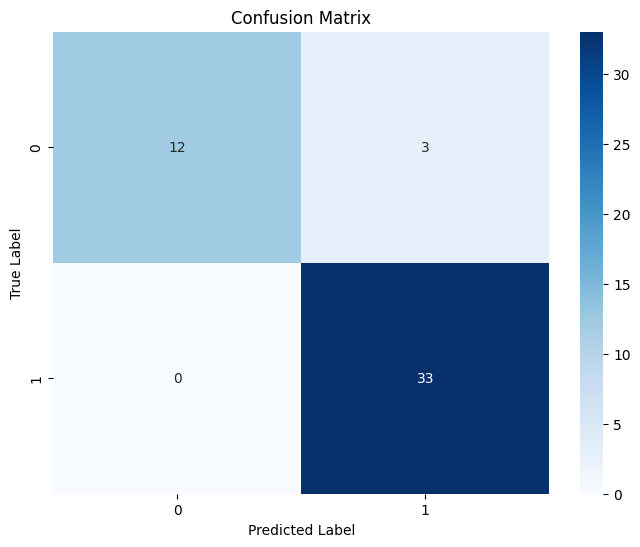

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Membuat confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Menampilkan confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=nb_classifier.classes_, yticklabels=nb_classifier.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
